## Arbol de Decisión para Clasificación

### Paso 1: Librerías

In [46]:
##Manipulación de la data
import numpy as np 
import pandas as pd 

##Graficar
import matplotlib.pyplot as plt 
import seaborn as sns 

##Evitar los warnings futuros
import warnings
warnings.filterwarnings('ignore')

##Librerías para test de normalidad
#import statsmodels.api as sm
from scipy import stats

##Librerias para preprocesamiento
from sklearn.preprocessing import MinMaxScaler, LabelEncoder

##Librerías para over y under sampling
from sklearn.utils import resample

##Librería para train y test split
from sklearn.model_selection import train_test_split

##Librerías para graficar rendimiento del modelo sin balanceo
from sklearn.neighbors import KNeighborsClassifier
from scikitplot.metrics import plot_roc
from scikitplot.metrics import plot_precision_recall
from sklearn.tree import DecisionTreeClassifier

### Funciones:


In [50]:
# Función para importar data .xlsx o .csv
def importDatos(ruta, archivo, ext, sep=None,encabe=None):
    if ext == '.csv':
        data = pd.read_csv(ruta+archivo+ext,sep=sep, header=encabe)
        return data
    elif ext == '.xlsx':
        data = pd.read_excel(ruta+archivo+ext)
        return data
    else:
        print('Extensión diferente')

# Función informe sobre los datos NAN


def datos_NA(df):
    if isinstance(df, pd.DataFrame):
        total_na = df.isna().sum().sum()
        print("Dimensiones : %d filas, %d columnas" %
              (df.shape[0], df.shape[1]))
        print("Total Valores NA : %d " % (total_na))
        print("%38s %10s     %10s %10s" %
              ("Nombre Columna", "Tipo de Dato", "#Distintos", "Valores NA"))
        col_name = df.columns
        dtyp = df.dtypes
        uniq = df.nunique()
        na_val = df.isna().sum()
        for i in range(len(df.columns)):
            print("%38s %10s   %10s %10s" %
                  (col_name[i], dtyp[i], uniq[i], na_val[i]))

    else:
        print("Se esperaba dataframe %15s" % (type(df)))

# Función para pintar algo el histograma reemplazamos con la media o mediana


def histoPlot(df, nomCol, anchoBar):
    sns.histplot(data=df, x=nomCol, binwidth=anchoBar, kde=True)

# Función para reemplazo de valore numéricos con la mediana


def imputacionNa(df, nomCol, param):
    if param == 'media':
        df[nomCol] = df[nomCol].fillna(df[nomCol].mean())
        return df[nomCol]
    else:
        df[nomCol] = df[nomCol].fillna(df[nomCol].median())
        return df[nomCol]
# Funcion para revisar datos categóricos o texto


def revCategoricos(df, nomCol):
    rev = df[nomCol].value_counts()
    return rev

# Función para datos categóricos modificaciones


def imputacionCat(df, nomCol, busqueda, reempl):
    df[nomCol] = np.where(df[nomCol] == busqueda, reempl, df[nomCol])
    return df[nomCol]

# Función para reeemplazo NA categóricos


def imputacionCatNa(df, nomCol):
    df[nomCol] = df[nomCol].fillna(df[nomCol].mode()[0])
    return df[nomCol]

# Función para cambiar datos de texto a numerico float64


def cambioTextNum(df, nomCol, tipo):
    df[nomCol] = df[nomCol].astype(tipo)
    return df[nomCol]

# Función modificar a 1 y 0 los datos categóricos


def camTextBi(df, nomCol, busqueda, camuno, camdos):
    df[nomCol] = np.where(df[nomCol] == busqueda, camuno, camdos)
    return df[nomCol]

# Función para variables dummies


def convDummies(df, nomCol):
    dummies = pd.get_dummies(df[nomCol])
    data = pd.concat([df, dummies], axis=1)
    data.drop(columns=[nomCol], inplace=True)
    return data

# Función cambiar encabezados del dataframe


def camEncab(df, listaN):
    df.columns = listaN
    return df

# Función para el test de Shapiro - wilk - resistente al ruido en los datos


def testShapiroWilk(df):
    valoresP = []
    concepto = []
    variable = []
    for column in df:
        k2, p_value = stats.shapiro(df[column].values)
        valoresP.append(p_value)
        variable.append(column)
        if (p_value < 0.05):
            concepto.append('No es una variable Normal')
        else:
            concepto.append('Es una variable Normal')
    dfShapiro = pd.DataFrame(
        {'Variable': variable, 'Valores P': valoresP, 'Concepto': concepto})
    return dfShapiro

# Función para normalizar la data min - max sklearn


def normaData(df):
    valores = df.values  
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaler = scaler.fit(valores)

    pd.DataFrame(np.vstack((scaler.data_min_, scaler.data_max_)),
             index=['Min', 'Max'],
             columns=df.columns)

    normalizados = scaler.transform(valores)
    df_norm = pd.DataFrame(normalizados,
                       index=df.index,
                       columns=df.columns)
    return df_norm

## Función para hacer la matriz de correlación de manera Tidy
def tidy_corr_matrix(corr_mat):
    '''
    Función para convertir una matriz de correlación de pandas en formato tidy.
    '''
    corr_mat = corr_mat.stack().reset_index()
    corr_mat.columns = ['variable_1','variable_2','r']
    corr_mat = corr_mat.loc[corr_mat['variable_1'] != corr_mat['variable_2'], :]
    corr_mat['abs_r'] = np.abs(corr_mat['r'])
    corr_mat = corr_mat.sort_values('abs_r', ascending=False)
    
    return(corr_mat)

##Función de label encoder
def Codificacion(df, nomCol):
    label_e = LabelEncoder()
    df[nomCol] = label_e.fit_transform(df[nomCol])
    return df[nomCol]


##Función para correlaciones
def grafCor(matriz):
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 8))
    sns.heatmap(
        matriz,
        annot     = True,
        cbar      = True,
        annot_kws = {"size": 10},
        vmin      = -1,
        vmax      = 1,
        center    = 0,
        cmap      = sns.light_palette("#0d47a1"),
        square    = True,
        ax        = ax,
        linewidth=.5
    )

    ax.set_xticklabels(
        ax.get_xticklabels(),
        rotation = 45,
        horizontalalignment = 'right',
    )

    ax.tick_params(labelsize = 10)

##Función para revisión de frecuencias absolutas
def revCategoA(df):
    for i in df.columns:
        #print(round(df[i].value_counts()/np.float64(len(df)),3))
        print(df[i].value_counts())

##Función para particionar la data con base en los nombres de encabezados
def partEnc(df, nomVar):
    listaCol = []
    for i in df.columns:
        if i !=nomVar:
            listaCol.append(i)
    return listaCol

###Función para graficar el desbalanceo en la variable predictora
def grafDes(varytrain, nomx, nomy, titulo):
    conteo = varytrain.value_counts()
    conteo.plot.bar()
    plt.ylabel(nomy)
    plt.xlabel(nomx)
    plt.title(titulo)
    plt.show()

##Función para graficar modelos en su precisión y recall
def grafModelos(xtrain, ytrain, xtest, ytest):
    modelo = DecisionTreeClassifier()

    modelo.fit(xtrain, ytrain)
    
    y_score= modelo.predict_proba(xtest)

    y_pred = modelo.predict(xtest)

    plot_roc(ytest, y_score)
    plt.show()

    plot_precision_recall(ytest, y_score)
    plt.show()


### Paso 1: Importación

In [16]:
datos = importDatos('./Datasets/','car_evaluation','.csv')
datos.head()

,0,1,2,3,4,5,6
0,vhigh,vhigh,2,2,small,low,unacc
1,vhigh,vhigh,2,2,small,med,unacc
2,vhigh,vhigh,2,2,small,high,unacc
3,vhigh,vhigh,2,2,med,low,unacc
4,vhigh,vhigh,2,2,med,med,unacc


In [17]:
##Cambios de encabezado
datos = camEncab(datos, ['Vcompra','Mante','CantPuertas','CantPer','CapacBaul','Seguridad','Clase'])

datos.head()

,Vcompra,Mante,CantPuertas,CantPer,CapacBaul,Seguridad,Clase
0,vhigh,vhigh,2,2,small,low,unacc
1,vhigh,vhigh,2,2,small,med,unacc
2,vhigh,vhigh,2,2,small,high,unacc
3,vhigh,vhigh,2,2,med,low,unacc
4,vhigh,vhigh,2,2,med,med,unacc


In [24]:
revCategoA(datos)

vhigh    0.25
high     0.25
med      0.25
low      0.25
Name: Vcompra, dtype: float64
vhigh    0.25
high     0.25
med      0.25
low      0.25
Name: Mante, dtype: float64
2        0.25
3        0.25
4        0.25
5more    0.25
Name: CantPuertas, dtype: float64
2       0.333
4       0.333
more    0.333
Name: CantPer, dtype: float64
small    0.333
med      0.333
big      0.333
Name: CapacBaul, dtype: float64
low     0.333
med     0.333
high    0.333
Name: Seguridad, dtype: float64
unacc    0.700
acc      0.222
good     0.040
vgood    0.038
Name: Clase, dtype: float64


In [26]:
##revisar datos NAN
datos_NA(datos)

Dimensiones : 1728 filas, 7 columnas
Total Valores NA : 0 
                        Nombre Columna Tipo de Dato     #Distintos Valores NA
                               Vcompra     object            4          0
                                 Mante     object            4          0
                           CantPuertas     object            4          0
                               CantPer     object            3          0
                             CapacBaul     object            3          0
                             Seguridad     object            3          0
                                 Clase     object            4          0


In [27]:
## Revisar la categoría para clasificar
revCategoricos(datos, 'Clase')

unacc    1210
acc       384
good       69
vgood      65
Name: Clase, dtype: int64

### Paso 2: Limpieza y balanceo del dataframe

In [29]:
datos.Vcompra = Codificacion(datos, 'Vcompra')
datos.Mante = Codificacion(datos, 'Mante')
datos.CantPuertas = Codificacion(datos, 'CantPuertas')
datos.CantPer = Codificacion(datos, 'CantPer')
datos.CapacBaul = Codificacion(datos, 'CapacBaul')
datos.Seguridad = Codificacion(datos, 'Seguridad')

In [39]:
##Particionar la data X & y y graficar del desbalanceo de la variable Clase - Clasificar (Imbalanced Clasification)
X = datos[partEnc(datos,'Clase')]
y = datos['Clase']



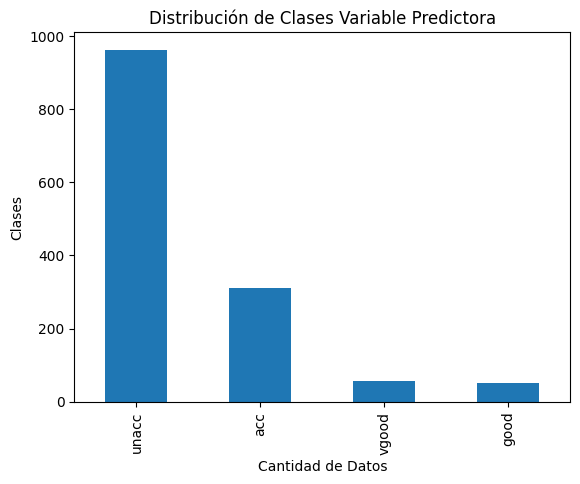

In [54]:
##Particion de la data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=100)

grafDes(y_train, 'Cantidad de Datos','Clases','Distribución de Clases Variable Predictora')

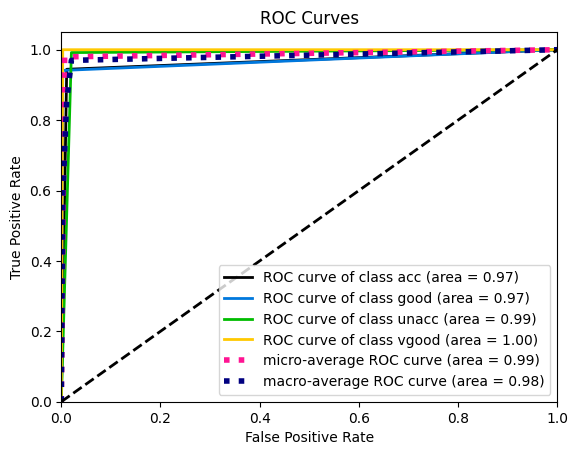

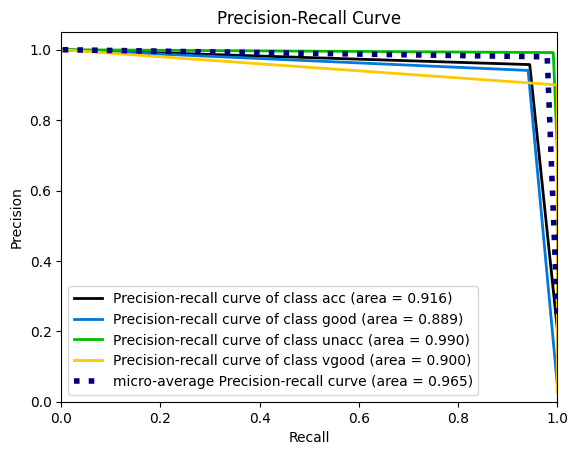

In [68]:
###Revisión de precisión y recall de las clases sin balancear

grafModelos(X_train, y_train, X_test, y_test)
